Epoch [1/20], Loss: 1.8717, Current LR: 0.000340
Test Accuracy: 47.95%
Epoch [2/20], Loss: 1.5964, Current LR: 0.000670
Test Accuracy: 65.70%
Epoch [3/20], Loss: 1.4864, Current LR: 0.001000
Test Accuracy: 64.60%
Epoch [4/20], Loss: 1.4121, Current LR: 0.001000
Test Accuracy: 63.36%
Epoch [5/20], Loss: 1.3323, Current LR: 0.000992
Test Accuracy: 76.75%
Epoch [6/20], Loss: 1.3062, Current LR: 0.000967
Test Accuracy: 77.72%
Epoch [7/20], Loss: 1.2936, Current LR: 0.000926
Test Accuracy: 80.43%
Epoch [8/20], Loss: 1.2395, Current LR: 0.000871
Test Accuracy: 83.23%
Epoch [9/20], Loss: 1.2131, Current LR: 0.000803
Test Accuracy: 85.08%
Epoch [10/20], Loss: 1.1931, Current LR: 0.000726
Test Accuracy: 83.63%
Epoch [11/20], Loss: 1.1294, Current LR: 0.000640
Test Accuracy: 87.64%
Epoch [12/20], Loss: 1.1179, Current LR: 0.000551
Test Accuracy: 86.29%
Epoch [13/20], Loss: 1.0908, Current LR: 0.000459
Test Accuracy: 88.88%
Epoch [14/20], Loss: 1.0835, Current LR: 0.000370
Test Accuracy: 90.10%
E

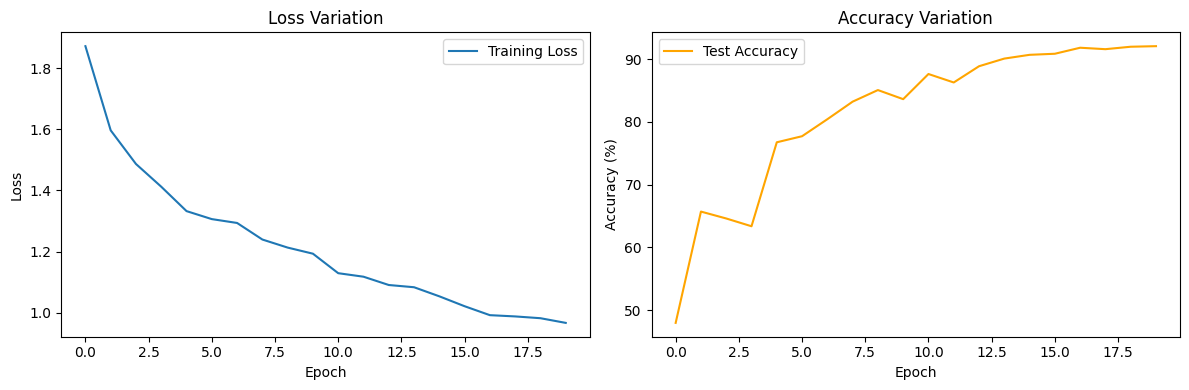

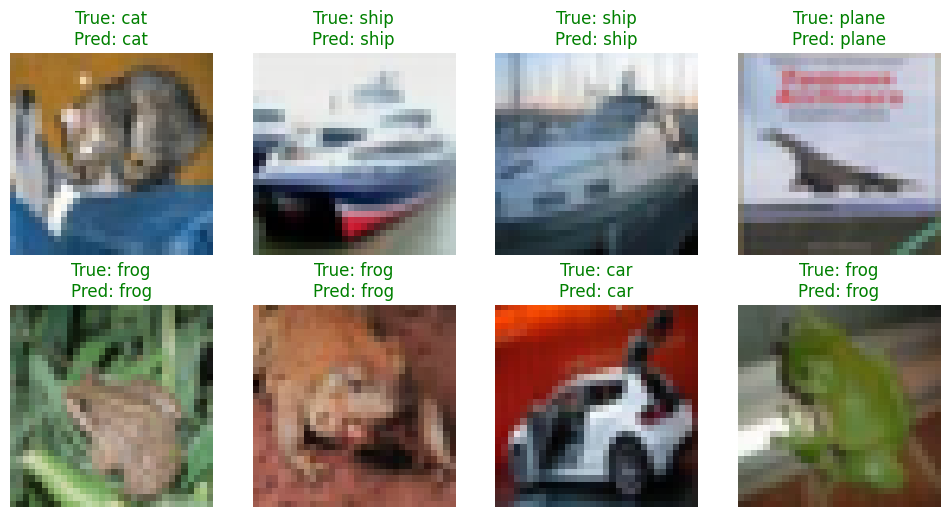


最优测试准确率：92.08%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR
import matplotlib.pyplot as plt
import numpy as np
from thop import profile, clever_format  # 计算参数量和FLOPs

# ===================== 1. 数据预处理（含MixUp增强） =====================
# 训练集增强：添加随机裁剪、水平翻转（提升泛化），MixUp在训练循环中实现
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 随机裁剪，填充4像素
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 测试集仅做标准化（保证评估真实）
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

# ===================== 2. 模型结构优化（引入残差连接） =====================
class ResidualBlock(nn.Module):
    """残差块：解决深层网络梯度消失问题，提升特征复用"""
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # 加速收敛，抑制过拟合
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 短接路径：当通道数/步长不一致时，用1x1卷积匹配维度
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)  # 残差连接
        out = self.relu(out)
        return out

class ResNet18_CIFAR(nn.Module):
    """基于ResNet18的轻量化改造，适配CIFAR10（32x32输入）"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_channels = 64
        # 初始卷积层：将3通道转为64通道，步长1（CIFAR10尺寸小，无需步长2）
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # 4个残差层，每层2个残差块 其中类似VGG的卷积和池化隐藏在其中
        self.layer1 = self._make_layer(64, 2, stride=1)     #32*32 -> 32*32
        self.layer2 = self._make_layer(128, 2, stride=2)    #32*32 -> 16*16
        self.layer3 = self._make_layer(256, 2, stride=2)    #16*16 -> 8*8
        self.layer4 = self._make_layer(512, 2, stride=2)    #8*8 -> 4*4
        
        # 全局平均池化（替代全连接层的扁平操作，减少参数量）
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))        #4*4 -> 1*1
        self.fc = nn.Linear(512, num_classes)  # 最终分类层

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels     # 更新输入通道数为当前层输出通道数
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# ===================== 3. 训练策略优化（Warmup + MixUp） =====================
def mixup_data(x, y, alpha=1.0, device='cuda'):
    """
    MixUp实现：按beta分布采样权重，混合两张图片和标签
    :param x: 输入图像 (batch_size, C, H, W)
    :param y: 标签 (batch_size,)
    :param alpha: beta分布参数，alpha=0时关闭MixUp
    :return: 混合后的图像、标签1、标签2、混合权重
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)  # 随机打乱批次索引

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """MixUp损失函数：加权交叉熵损失"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ===================== 4. 初始化组件 =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18_CIFAR().to(device)

# 损失函数与优化器（用AdamW替代Adam，添加权重衰减抑制过拟合）
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)

# 学习率调度器：前3个epoch Warmup（从0升到0.001），后续CosineAnnealing下降
warmup_epochs = 3
scheduler = LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs * len(train_loader))
# 预热结束后切换为余弦退火
main_scheduler = CosineAnnealingLR(optimizer, T_max=20 - warmup_epochs, eta_min=1e-5)

# 记录训练过程
train_losses = []
test_accuracies = []
best_acc = 0.0

# ===================== 5. 训练与验证循环 =====================
def train(epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # 应用MixUp
        data, target_a, target_b, lam = mixup_data(data, target, alpha=1.0, device=device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = mixup_criterion(criterion, output, target_a, target_b, lam)
        loss.backward()
        optimizer.step()
        
        # 更新学习率（Warmup阶段）
        if epoch <= warmup_epochs:
            scheduler.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch}/20], Loss: {avg_loss:.4f}, Current LR: {optimizer.param_groups[0]["lr"]:.6f}')

def test(epoch):
    global best_acc
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    acc = 100 * correct / total
    test_accuracies.append(acc)
    print(f'Test Accuracy: {acc:.2f}%')
    
    # 保存最优模型
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_resnet18_cifar10.pth')
    
    # 预热结束后，更新余弦退火调度器
    if epoch > warmup_epochs:
        main_scheduler.step()
    
    return acc

# 执行训练
for epoch in range(1, 21):
    train(epoch)
    test(epoch)

# ===================== 6. 硬性指标：计算参数量与FLOPs =====================
def calculate_model_complexity(model, input_size=(3, 32, 32)):
    """计算模型参数量和FLOPs"""
    model.eval()
    input_tensor = torch.randn(1, *input_size).to(device)
    flops, params = profile(model, inputs=(input_tensor,), verbose=False)
    flops, params = clever_format((flops, params), "%.3f")
    print(f"\n模型复杂度评估（输入尺寸：{input_size}）：")
    print(f"总参数量：{params}")
    print(f"总计算量（FLOPs）：{flops}")
    return flops, params

calculate_model_complexity(model)

# ===================== 7. 结果可视化 =====================
# 1. Loss与Accuracy曲线
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Variation')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Variation')
plt.legend()
plt.tight_layout()
plt.show()

# 2. 分类结果可视化
def plot_predictions():
    model.load_state_dict (torch.load ('best_resnet18_cifar10.pth'), strict=False)  # 加载最优模型
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}', 
                  color='green' if predicted[i]==labels[i] else 'red')
        plt.axis('off')
    plt.show()

plot_predictions()
print(f"\n最优测试准确率：{best_acc:.2f}%")